In [1]:
# Setup and Imports

import sys
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)

import numpy as np
from nilearn import image
from scipy import stats
import pandas as pd
import os
from tqdm import tqdm
import warnings
import subprocess

# Define parameters
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
raw_dir = "/lab_data/behrmannlab/vlad/hemispace"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"

# Load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

# Define analysis type (change this to switch between 'fc' and 'ppi')
analysis_type = 'ppi'  # or 'fc'

# Define paths for input files
pIPS_path = f"{study_dir}/{{subject_id}}/ses-01/derivatives/fc/{{subject_id}}_pIPS_{{hemi}}_loc_{analysis_type}.nii.gz"
LO_path = f"{study_dir}/{{subject_id}}/ses-01/derivatives/fc/{{subject_id}}_LO_{{hemi}}_loc_{analysis_type}.nii.gz"

# Define output directories
group_out_dir = f'{curr_dir}/analyses/{analysis_type}_subtraction'
os.makedirs(group_out_dir, exist_ok=True)

In [ ]:
# Subtraction

def load_and_subtract_maps(pIPS_path, LO_path):
    pIPS_map = image.load_img(pIPS_path)
    LO_map = image.load_img(LO_path)
    difference_map = image.math_img("img1 - img2", img1=LO_map, img2=pIPS_map)
    return difference_map

def subject_level_analysis(subject_id, pIPS_path, LO_path, output_dir, hemi):
    pIPS_file = pIPS_path.format(subject_id=subject_id, hemi=hemi)
    LO_file = LO_path.format(subject_id=subject_id, hemi=hemi)
    
    if not os.path.exists(pIPS_file) or not os.path.exists(LO_file):
        print(f"Warning: Files not found for subject {subject_id}, hemisphere {hemi}. Skipping.")
        return None

    difference_map = load_and_subtract_maps(pIPS_file, LO_file)
    
    subtraction_file = os.path.join(output_dir, f'{subject_id}_LO_minus_pIPS_{hemi}_{analysis_type}.nii.gz')
    difference_map.to_filename(subtraction_file)
    
    print(f"Subtraction complete for subject {subject_id}, hemisphere {hemi}. Result saved in {subtraction_file}")
    return subtraction_file

# Perform subject-level analysis and collect subtraction files
subtraction_files = {'left': [], 'right': []}

for sub in tqdm(subs, desc="Processing subjects"):
    sub_dir = f"{study_dir}/{sub}/ses-01"
    out_dir = f"{sub_dir}/derivatives"
    analysis_dir = f"{out_dir}/{analysis_type}"
    os.makedirs(analysis_dir, exist_ok=True)

    for hemi in ['left', 'right']:
        subtraction_file = subject_level_analysis(sub, pIPS_path, LO_path, analysis_dir, hemi)
        if subtraction_file:
            subtraction_files[hemi].append(subtraction_file)

print(f"Subtraction completed for all subjects using {analysis_type} analysis.")


In [ ]:
# Conversion to Standard Space
# alt run sub2stand.py in terminal
#(fmri) (base) [csimmon2@mind-1-21-2 ptoc]$ module load fsl-6.0.3 
#(fmri) (base) [csimmon2@mind-1-21-2 ptoc]$ python analyses/fc_subtraction/sub2stand.py 

mni_brain = os.path.join(os.environ['FSLDIR'], "data/standard/MNI152_T1_2mm_brain.nii.gz")

def convert_to_mni(sub, input_file, output_file, anat2mni_mat, mni_brain):
    if not os.path.isfile(input_file):
        print(f"Input file not found: {input_file}")
        return None

    if os.path.isfile(output_file):
        print(f"MNI file already exists: {output_file}")
        return output_file

    print(f"Converting to MNI space for {sub}")
    subprocess.run([
        'flirt',
        '-in', input_file,
        '-ref', mni_brain,
        '-out', output_file,
        '-applyxfm',
        '-init', anat2mni_mat,
        '-interp', 'trilinear'
    ], check=True)

    return output_file

mni_files = {'left': [], 'right': []}

for sub in tqdm(subs, desc="Converting to MNI space"):
    sub_dir = f"{study_dir}/{sub}/ses-01"
    out_dir = f"{sub_dir}/derivatives"
    fc_dir = f"{out_dir}/fc"
    fc_mni_dir = f"{out_dir}/fc_mni"
    os.makedirs(fc_mni_dir, exist_ok=True)

    # Generate transformation matrix if it doesn't exist
    anat2mni_mat = f"{out_dir}/anat2mni.mat"
    if not os.path.isfile(anat2mni_mat):
        anat_brain = f"{raw_dir}/{sub}/ses-01/anat/{sub}_ses-01_T1w_brain.nii.gz"
        if not os.path.isfile(anat_brain):
            print(f"Anatomical image not found for {sub}. Skipping...")
            continue
        print(f"Generating transformation matrix for {sub}")
        subprocess.run([
            'flirt',
            '-in', anat_brain,
            '-ref', mni_brain,
            '-omat', anat2mni_mat,
            '-bins', '256',
            '-cost', 'corratio',
            '-searchrx', '-90', '90',
            '-searchry', '-90', '90',
            '-searchrz', '-90', '90',
            '-dof', '12'
        ], check=True)

    for hemi in ['left', 'right']:
        input_file = f"{fc_dir}/{sub}_LO_minus_pIPS_{hemi}_fc.nii.gz"
        mni_file = f"{fc_mni_dir}/{sub}_LO_minus_pIPS_{hemi}_fc_mni.nii.gz"
        mni_result = convert_to_mni(sub, input_file, mni_file, anat2mni_mat, mni_brain)
        if mni_result:
            mni_files[hemi].append(mni_result)

print("Conversion to MNI space completed for all subjects.")

In [3]:
# Statistics

import os
import numpy as np
from nilearn import image
import pandas as pd
from tqdm import tqdm

# Setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
study_dir = "/lab_data/behrmannlab/vlad/ptoc"

# Load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

# Define output directory for group analysis
group_out_dir = f'{curr_dir}/analyses/{analysis_type}_subtraction'
os.makedirs(group_out_dir, exist_ok=True)

def safe_divide(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0  # replace inf/NaN with 0
    return c

def group_level_analysis(mni_files, output_dir, hemi):
    if not mni_files:
        print(f"Error: No valid MNI space files for {hemi} hemisphere. Skipping t-test.")
        return

    print(f"Processing {len(mni_files)} files for {hemi} hemisphere")

    # Load all MNI space maps
    all_maps = [image.load_img(f) for f in mni_files]

    # Stack all maps into a 4D image
    stacked_maps = image.concat_imgs(all_maps)

    # Perform voxel-wise one-sample t-test
    print(f"Performing t-test for {hemi} hemisphere")
    data = stacked_maps.get_fdata()
    mean = np.mean(data, axis=-1)
    std = np.std(data, axis=-1)
    n = data.shape[-1]
    t_values = safe_divide(mean, (std / np.sqrt(n)))

    # Create and save the t-map
    t_map = image.new_img_like(all_maps[0], t_values)
    t_map_file = os.path.join(output_dir, f'group_ttest_LO_minus_pIPS_{hemi}_{analysis_type}.nii.gz')
    t_map.to_filename(t_map_file)

    print(f"Group-level analysis complete for {hemi} hemisphere. T-map saved in {t_map_file}")

# Collect MNI files
mni_files = {'left': [], 'right': []}

for sub in tqdm(subs, desc="Collecting MNI files"):
    sub_dir = f"{study_dir}/{sub}/ses-01"
    analysis_mni_dir = f"{sub_dir}/derivatives/{analysis_type}_mni"
    
    for hemi in ['left', 'right']:
        mni_file = f"{analysis_mni_dir}/{sub}_LO_minus_pIPS_{hemi}_{analysis_type}_mni.nii.gz"
        if os.path.exists(mni_file):
            mni_files[hemi].append(mni_file)
        else:
            print(f"Warning: MNI file not found for subject {sub}, hemisphere {hemi}")

# Perform group-level analysis
for hemi in ['left', 'right']:
    group_level_analysis(mni_files[hemi], group_out_dir, hemi)

print(f"Analysis completed for both hemispheres using {analysis_type} analysis.")

Processing 19 files for left hemisphere
Performing t-test for left hemisphere
Group-level analysis complete for left hemisphere. T-map saved in /user_data/csimmon2/git_repos/ptoc/analyses/ppi_subtraction/group_ttest_LO_minus_pIPS_left_ppi.nii.gz
Processing 19 files for right hemisphere
Performing t-test for right hemisphere
Group-level analysis complete for right hemisphere. T-map saved in /user_data/csimmon2/git_repos/ptoc/analyses/ppi_subtraction/group_ttest_LO_minus_pIPS_right_ppi.nii.gz
Analysis completed for both hemispheres using ppi analysis.


/tmp/ipykernel_9483/3070104078.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


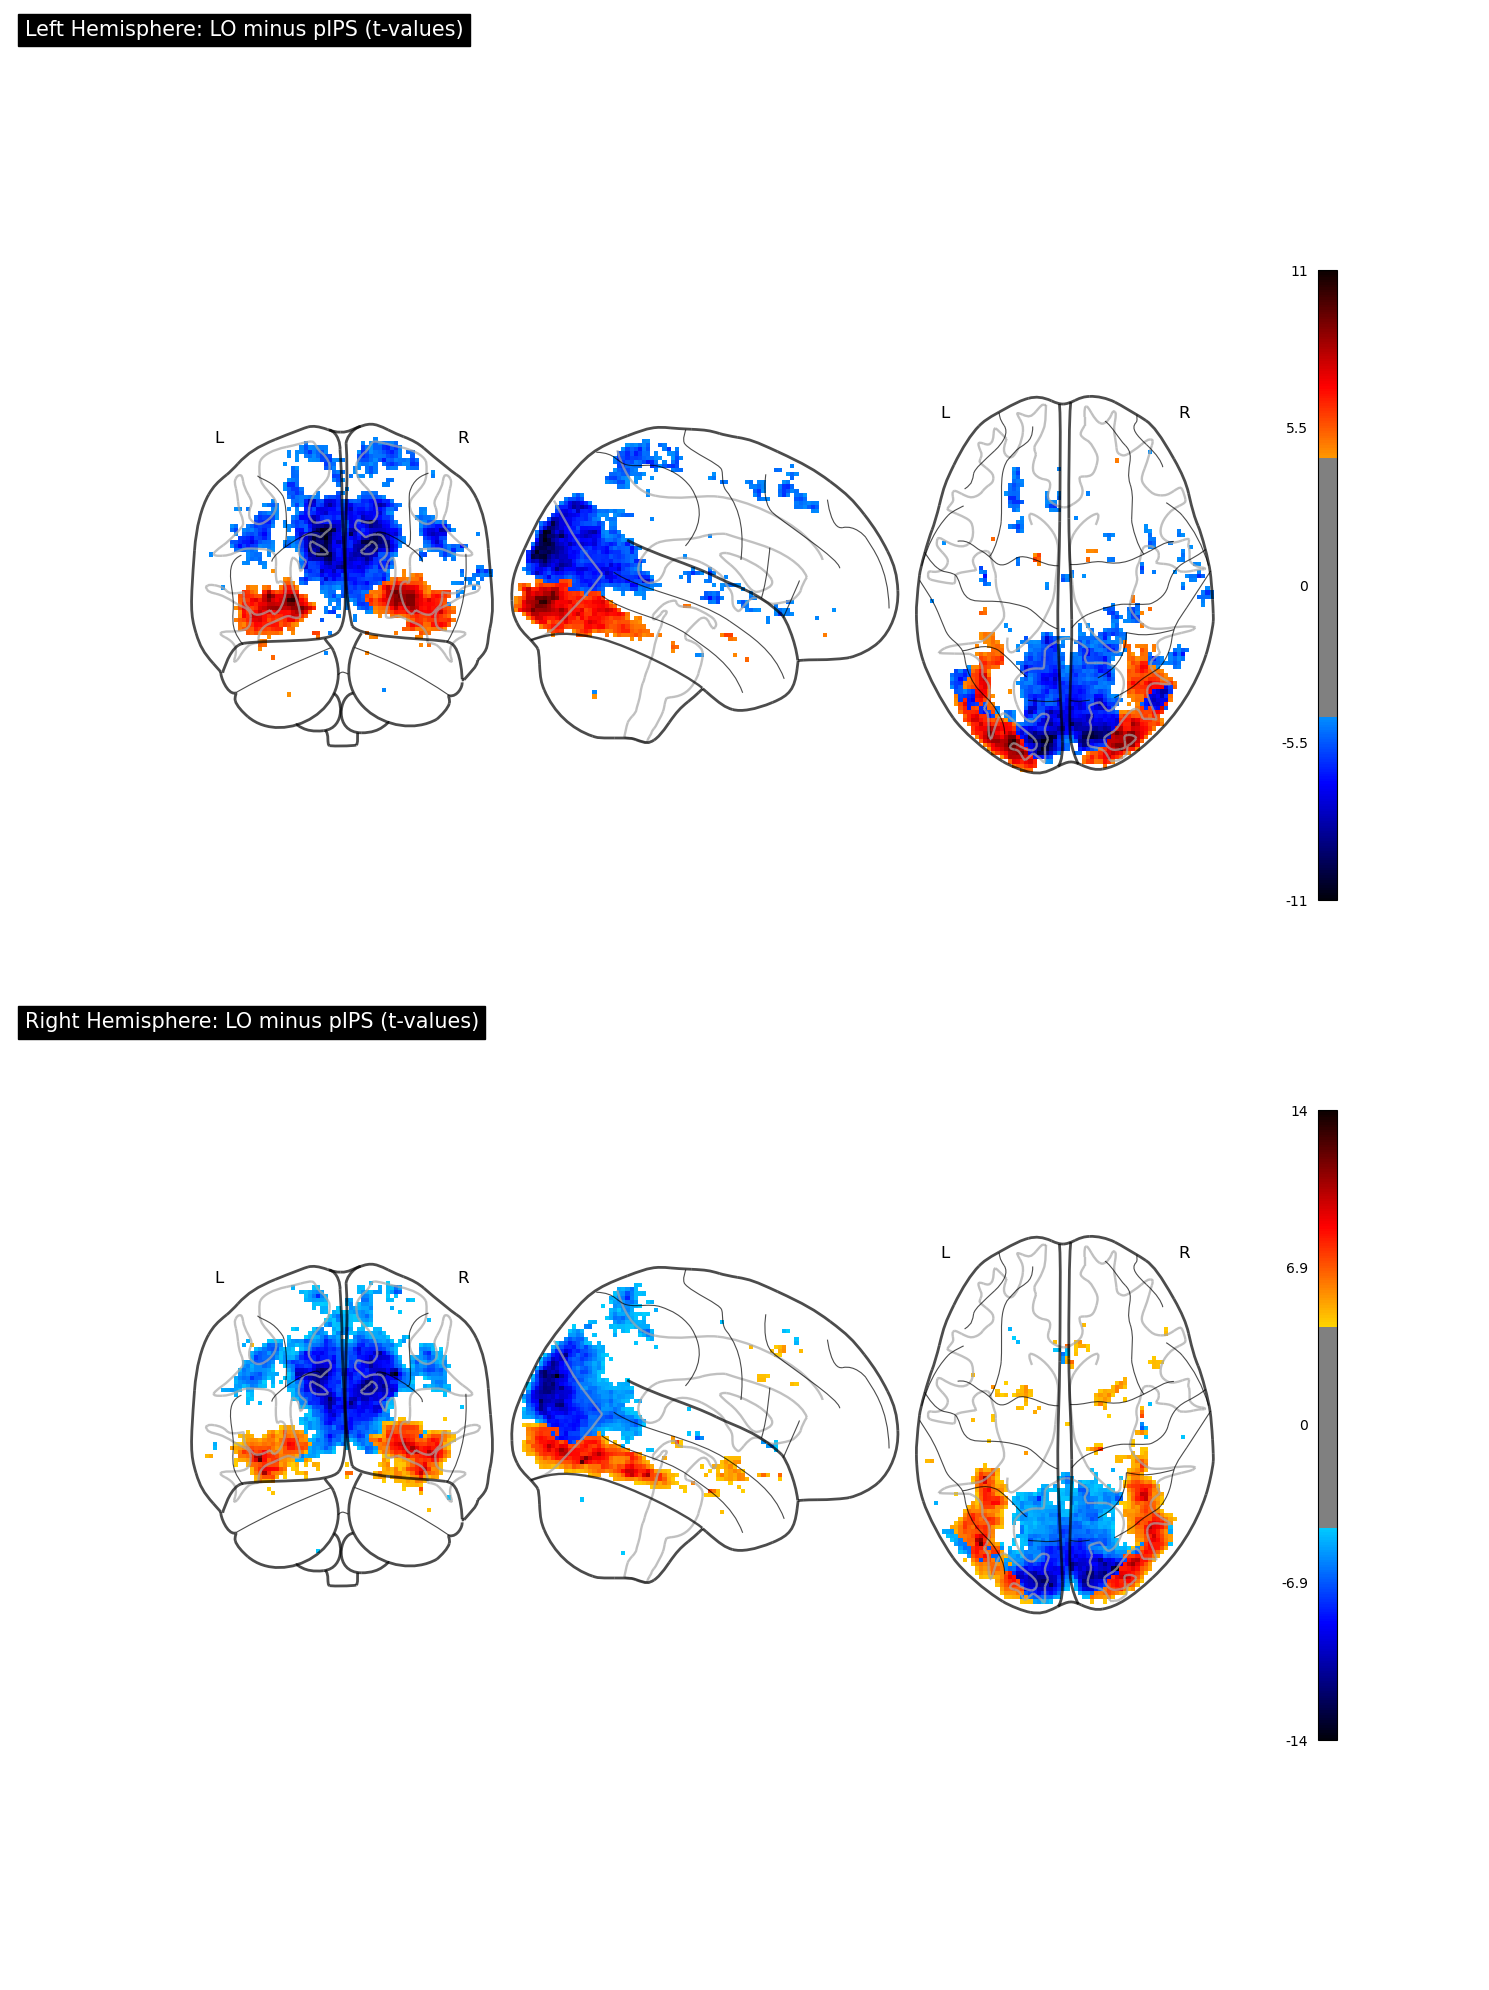

Left Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Right Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Figure saved as: /user_data/csimmon2/git_repos/ptoc/analyses/fc_subtraction/LO_minus_pIPS_tmap_results.png
Left hemisphere:
  Max t-value: 10.329
  Min t-value: -10.900
  Number of significant voxels: 10003

Right hemisphere:
  Max t-value: 12.251
  Min t-value: -13.839
  Number of significant voxels: 11410



In [2]:
##RUN ONLY FOR FC
# Visualize Results

import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
group_out_dir = f'{curr_dir}/analyses/fc_subtraction'

# Function to load and threshold t-map
def load_and_threshold_tmap(file_path, threshold):
    img = nib.load(file_path)
    data = img.get_fdata()
    thresholded_data = np.where(np.abs(data) > threshold, data, 0)
    return nib.Nifti1Image(thresholded_data, img.affine, img.header)

# Load t-maps
left_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_left.nii.gz')
right_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_right.nii.gz')

# Set threshold (you can adjust this value)
threshold = 4.5  # 2.5 This corresponds to p < 0.05 for a two-tailed t-test with large df

# Load and threshold t-maps
left_tmap_thresholded = load_and_threshold_tmap(left_tmap_file, threshold)
right_tmap_thresholded = load_and_threshold_tmap(right_tmap_file, threshold)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# Plot left hemisphere results
plotting.plot_glass_brain(left_tmap_thresholded, 
                          threshold=threshold,
                          colorbar=True, 
                          plot_abs=False,
                          title='Left Hemisphere: LO minus pIPS (t-values)',
                          axes=ax1)

# Plot right hemisphere results
plotting.plot_glass_brain(right_tmap_thresholded, 
                          threshold=threshold,
                          colorbar=True, 
                          plot_abs=False,
                          title='Right Hemisphere: LO minus pIPS (t-values)',
                          axes=ax2)

plt.tight_layout()
plt.show()

# You can also create interactive plots
print("Left Hemisphere Interactive Plot:")
plotting.view_img(left_tmap_thresholded, threshold=threshold, colorbar=True)

print("\nRight Hemisphere Interactive Plot:")
plotting.view_img(right_tmap_thresholded, threshold=threshold, colorbar=True)

# Save the figure
fig.savefig(os.path.join(group_out_dir, 'LO_minus_pIPS_tmap_results.png'), dpi=300, bbox_inches='tight')
print(f"\nFigure saved as: {os.path.join(group_out_dir, 'LO_minus_pIPS_tmap_results.png')}")

# Basic Stats
for hemi in ['left', 'right']:
    tmap = nib.load(os.path.join(group_out_dir, f'group_ttest_LO_minus_pIPS_{hemi}.nii.gz'))
    data = tmap.get_fdata()
    significant_voxels = np.sum(np.abs(data) > threshold)
    print(f"{hemi.capitalize()} hemisphere:")
    print(f"  Max t-value: {np.max(data):.3f}")
    print(f"  Min t-value: {np.min(data):.3f}")
    print(f"  Number of significant voxels: {significant_voxels}")
    print()

/tmp/ipykernel_9483/3316571510.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


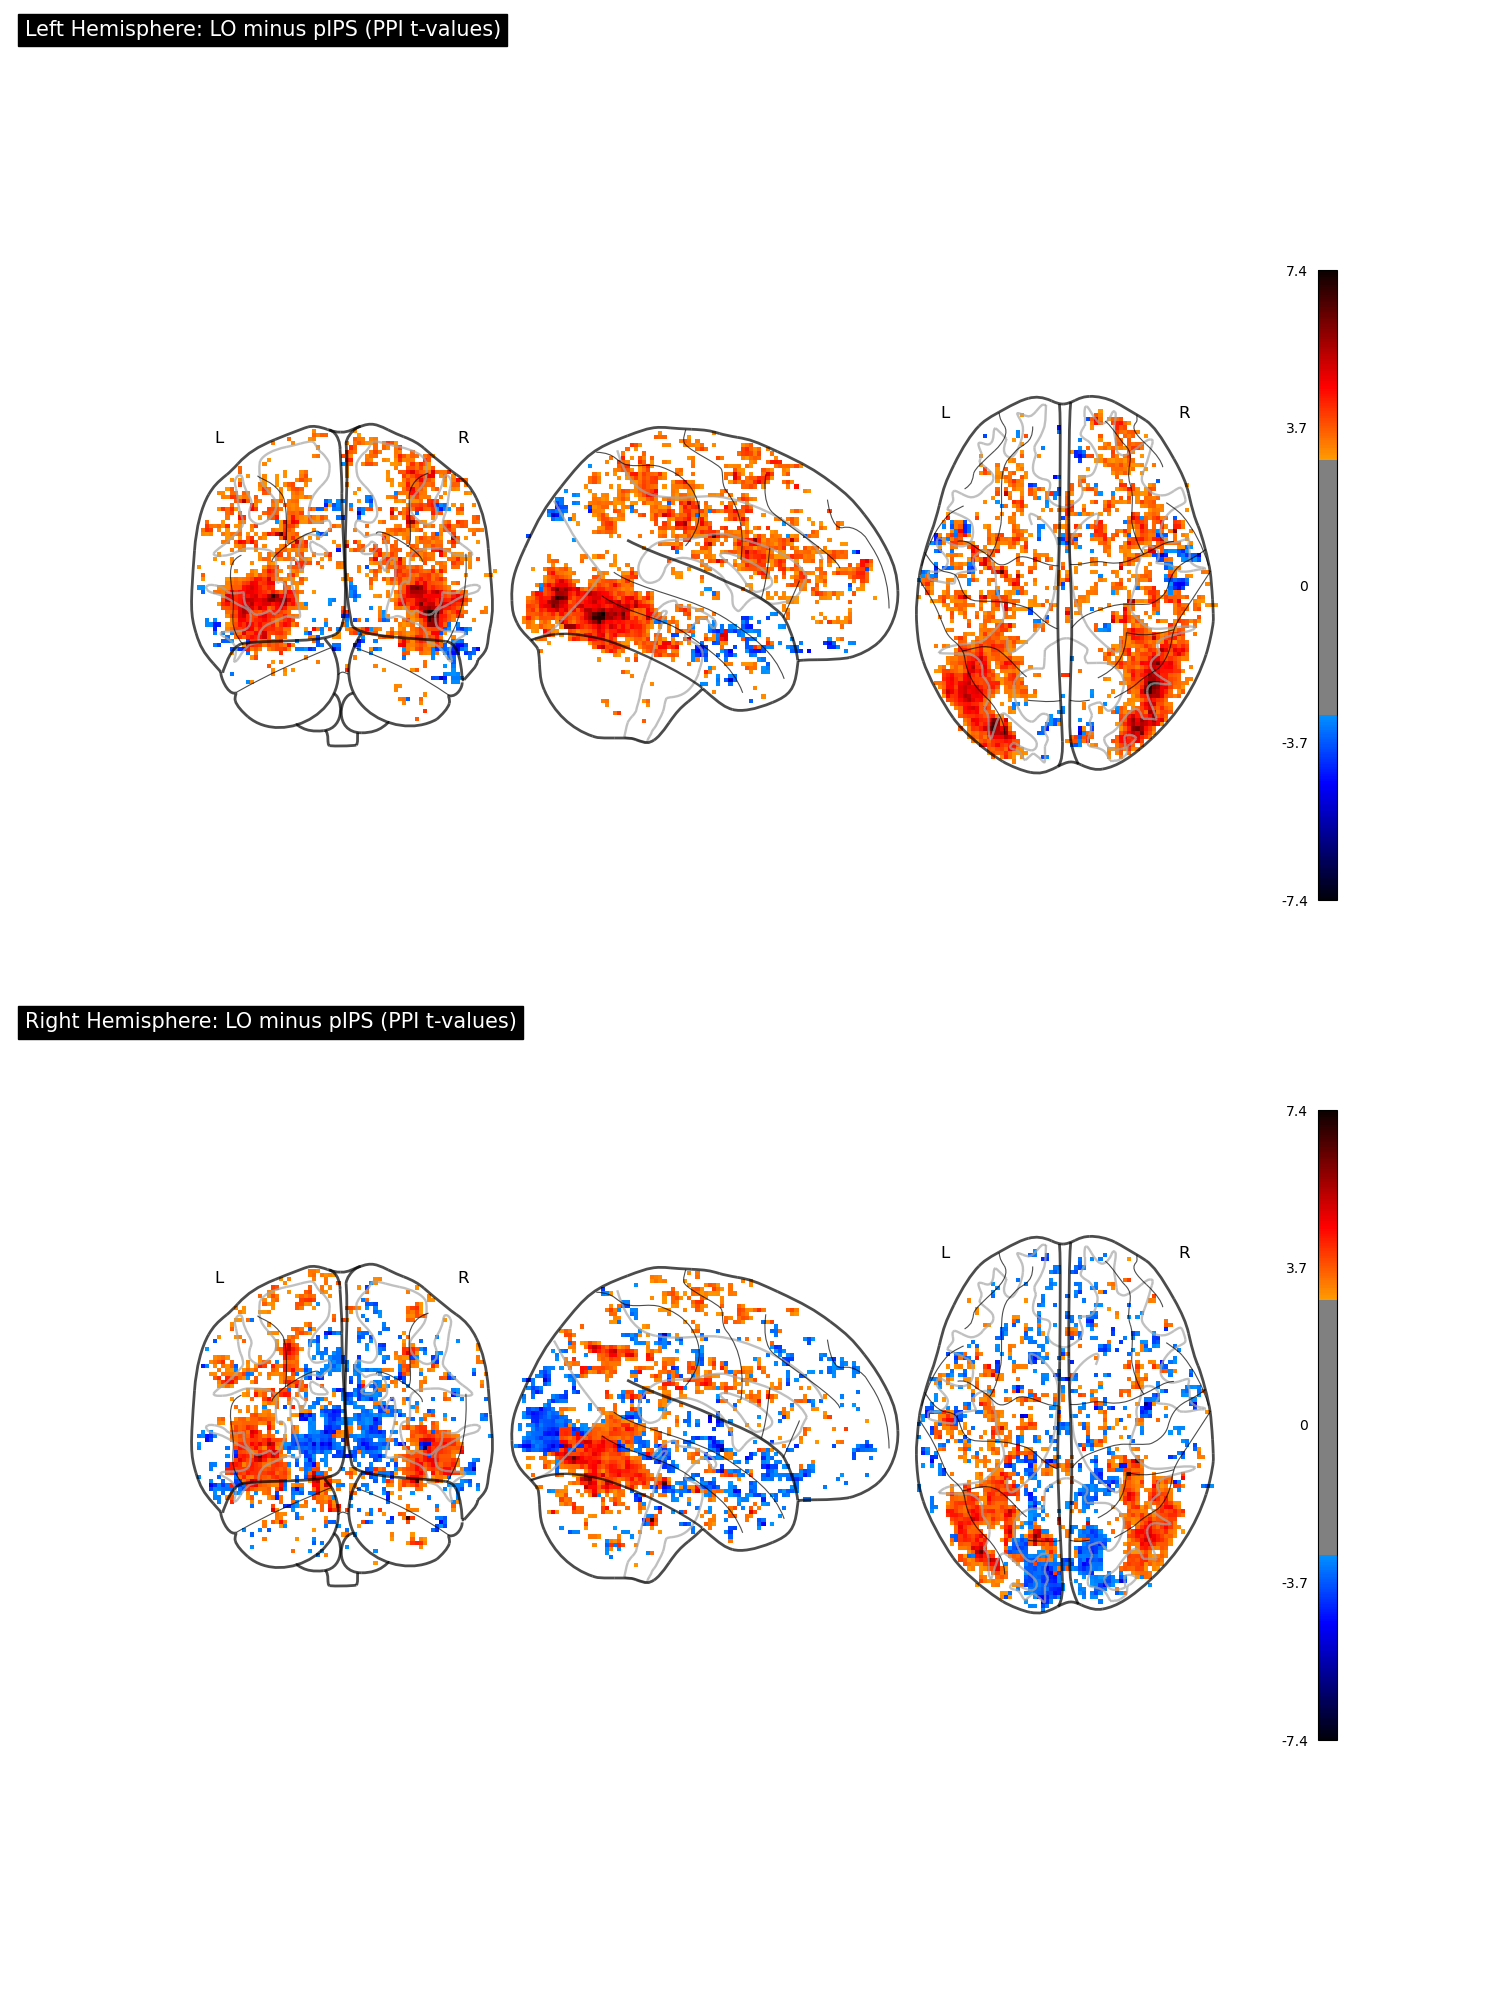


Figure saved as: /user_data/csimmon2/git_repos/ptoc/analyses/ppi_subtraction/LO_minus_pIPS_ppi_tmap_results.png
Left hemisphere (PPI):
  Max t-value: 7.379
  Min t-value: -5.260
  Number of significant voxels: 6531

Right hemisphere (PPI):
  Max t-value: 6.853
  Min t-value: -6.241
  Number of significant voxels: 4882

Scale range: -7.379 to 7.379


In [5]:
# Visualize Results - changed by analysis type
import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
group_out_dir = f'{curr_dir}/analyses/{analysis_type}_subtraction'

# Function to load and threshold t-map
def load_and_threshold_tmap(file_path, threshold):
    img = nib.load(file_path)
    data = img.get_fdata()
    thresholded_data = np.where(np.abs(data) > threshold, data, 0)
    return nib.Nifti1Image(thresholded_data, img.affine, img.header)

# Load t-maps
left_tmap_file = os.path.join(group_out_dir, f'group_ttest_LO_minus_pIPS_left_{analysis_type}.nii.gz')
right_tmap_file = os.path.join(group_out_dir, f'group_ttest_LO_minus_pIPS_right_{analysis_type}.nii.gz')

# Set threshold (you can adjust this value)
threshold = 3.0  # This corresponds to p < 0.05 for a two-tailed t-test with large df

# Load and threshold t-maps
left_tmap_thresholded = load_and_threshold_tmap(left_tmap_file, threshold)
right_tmap_thresholded = load_and_threshold_tmap(right_tmap_file, threshold)

# Set a consistent scale for both hemispheres
vmax = max(np.max(np.abs(left_tmap_thresholded.get_fdata())), 
           np.max(np.abs(right_tmap_thresholded.get_fdata())))
vmin = -vmax

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# Plot left hemisphere results
plotting.plot_glass_brain(left_tmap_thresholded,
                          threshold=threshold,
                          colorbar=True,
                          plot_abs=False,
                          vmin=vmin, vmax=vmax,
                          title=f'Left Hemisphere: LO minus pIPS ({analysis_type.upper()} t-values)',
                          axes=ax1)

# Plot right hemisphere results
plotting.plot_glass_brain(right_tmap_thresholded,
                          threshold=threshold,
                          colorbar=True,
                          plot_abs=False,
                          vmin=vmin, vmax=vmax,
                          title=f'Right Hemisphere: LO minus pIPS ({analysis_type.upper()} t-values)',
                          axes=ax2)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join(group_out_dir, f'LO_minus_pIPS_{analysis_type}_tmap_results.png'), dpi=300, bbox_inches='tight')
print(f"\nFigure saved as: {os.path.join(group_out_dir, f'LO_minus_pIPS_{analysis_type}_tmap_results.png')}")

# Basic Stats
for hemi in ['left', 'right']:
    tmap = nib.load(os.path.join(group_out_dir, f'group_ttest_LO_minus_pIPS_{hemi}_{analysis_type}.nii.gz'))
    data = tmap.get_fdata()
    significant_voxels = np.sum(np.abs(data) > threshold)
    print(f"{hemi.capitalize()} hemisphere ({analysis_type.upper()}):")
    print(f"  Max t-value: {np.max(data):.3f}")
    print(f"  Min t-value: {np.min(data):.3f}")
    print(f"  Number of significant voxels: {significant_voxels}")
    print()

print(f"Scale range: {vmin:.3f} to {vmax:.3f}")

/tmp/ipykernel_31203/1424415154.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


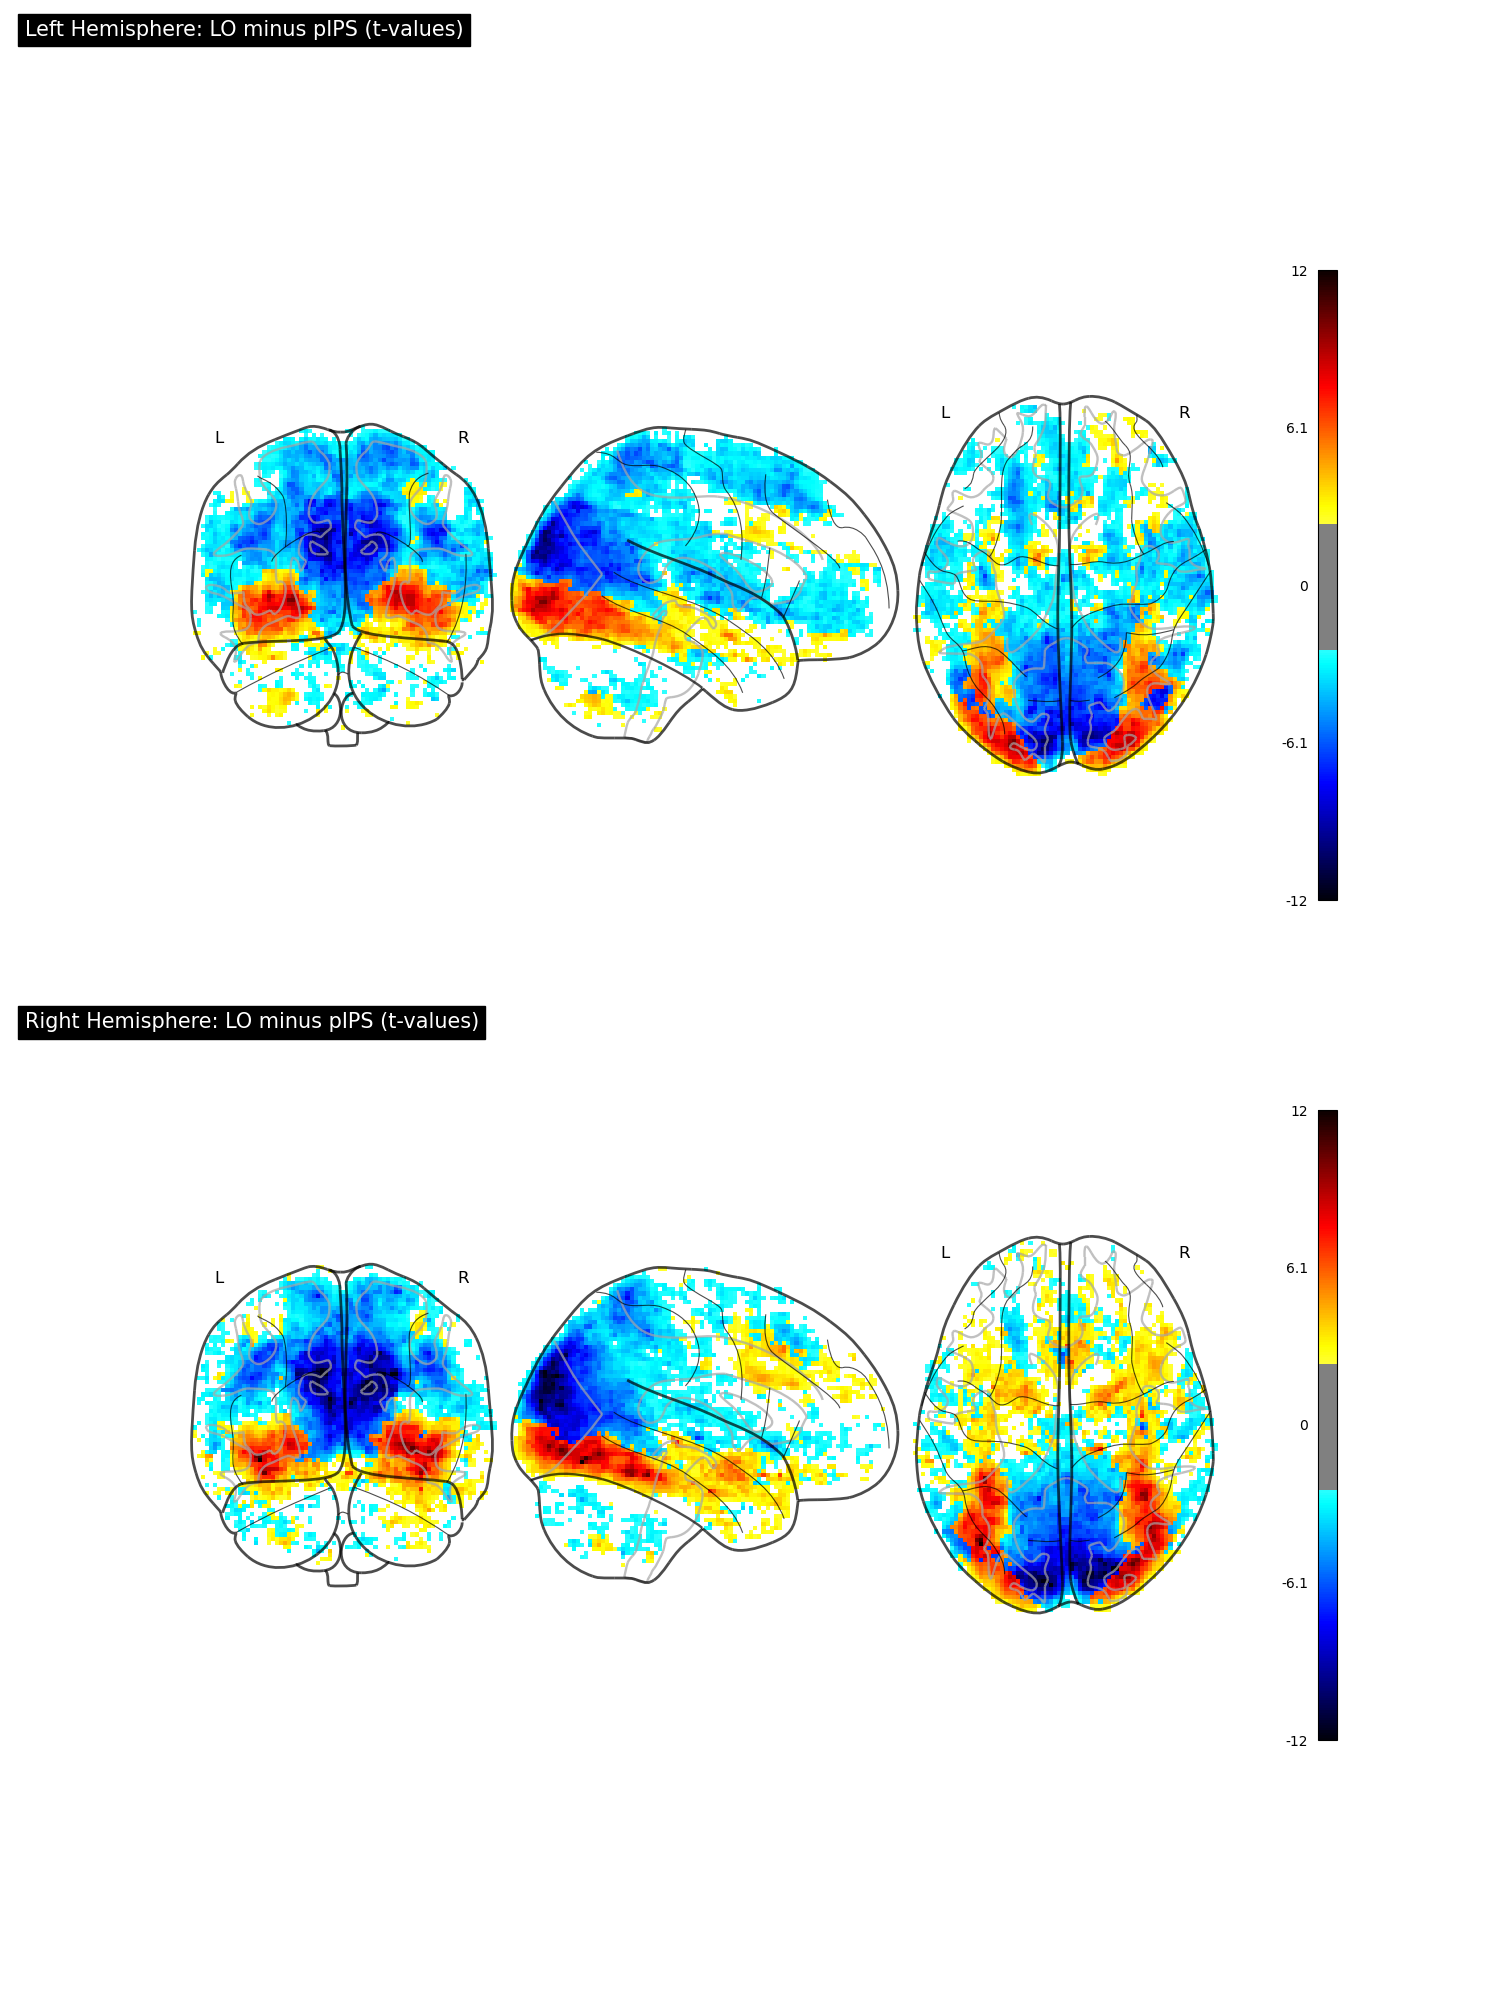


Figure saved as: /user_data/csimmon2/git_repos/ptoc/analyses/fc_subtraction/LO_minus_pIPS_tmap_results.png
Left Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Right Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Left hemisphere:
  Max t-value: 10.329
  Min t-value: -10.900
  Number of significant voxels: 40288

Right hemisphere:
  Max t-value: 12.251
  Min t-value: -13.839
  Number of significant voxels: 37397


In [2]:
# Cell 5: Visualize Results with Consistent Color Scale

import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
group_out_dir = f'{curr_dir}/analyses/fc_subtraction'

# Function to load and threshold t-map
def load_and_threshold_tmap(file_path, threshold):
    img = nib.load(file_path)
    data = img.get_fdata()
    thresholded_data = np.where(np.abs(data) > threshold, data, 0)
    return nib.Nifti1Image(thresholded_data, img.affine, img.header)

# Load t-maps
left_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_left.nii.gz')
right_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_right.nii.gz')

# Set threshold (you can adjust this value)
threshold = 2.5  # This corresponds to p < 0.05 for a two-tailed t-test with large df

# Load and threshold t-maps
left_tmap_thresholded = load_and_threshold_tmap(left_tmap_file, threshold)
right_tmap_thresholded = load_and_threshold_tmap(right_tmap_file, threshold)

# Determine the global min and max for color scaling
left_data = left_tmap_thresholded.get_fdata()
right_data = right_tmap_thresholded.get_fdata()
vmin = min(np.min(left_data), np.min(right_data))
vmax = max(np.max(left_data), np.max(right_data))

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# Plot left hemisphere results
plot_left = plotting.plot_glass_brain(left_tmap_thresholded, 
                                      threshold=threshold,
                                      colorbar=True, 
                                      plot_abs=False,
                                      vmin=vmin, vmax=vmax,
                                      title='Left Hemisphere: LO minus pIPS (t-values)',
                                      axes=ax1)

# Plot right hemisphere results
plot_right = plotting.plot_glass_brain(right_tmap_thresholded, 
                                       threshold=threshold,
                                       colorbar=True, 
                                       plot_abs=False,
                                       vmin=vmin, vmax=vmax,
                                       title='Right Hemisphere: LO minus pIPS (t-values)',
                                       axes=ax2)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join(group_out_dir, 'LO_minus_pIPS_tmap_results.png'), dpi=300, bbox_inches='tight')
print(f"\nFigure saved as: {os.path.join(group_out_dir, 'LO_minus_pIPS_tmap_results.png')}")

# Print some basic statistics
for hemi, tmap in zip(['left', 'right'], [left_tmap_thresholded, right_tmap_thresholded]):
    data = tmap.get_fdata()
    significant_voxels = np.sum(np.abs(data) > threshold)
    print(f"\n{hemi.capitalize()} hemisphere:")
    print(f"  Max t-value: {np.max(data):.3f}")
    print(f"  Min t-value: {np.min(data):.3f}")
    print(f"  Number of significant voxels: {significant_voxels}")

/tmp/ipykernel_31678/530772333.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Left hemisphere figure saved as: /user_data/csimmon2/git_repos/ptoc/analyses/fc_subtraction/LO_minus_pIPS_fc_tmap_results_left.png


/tmp/ipykernel_31678/530772333.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Right hemisphere figure saved as: /user_data/csimmon2/git_repos/ptoc/analyses/fc_subtraction/LO_minus_pIPS_fc_tmap_results_right.png


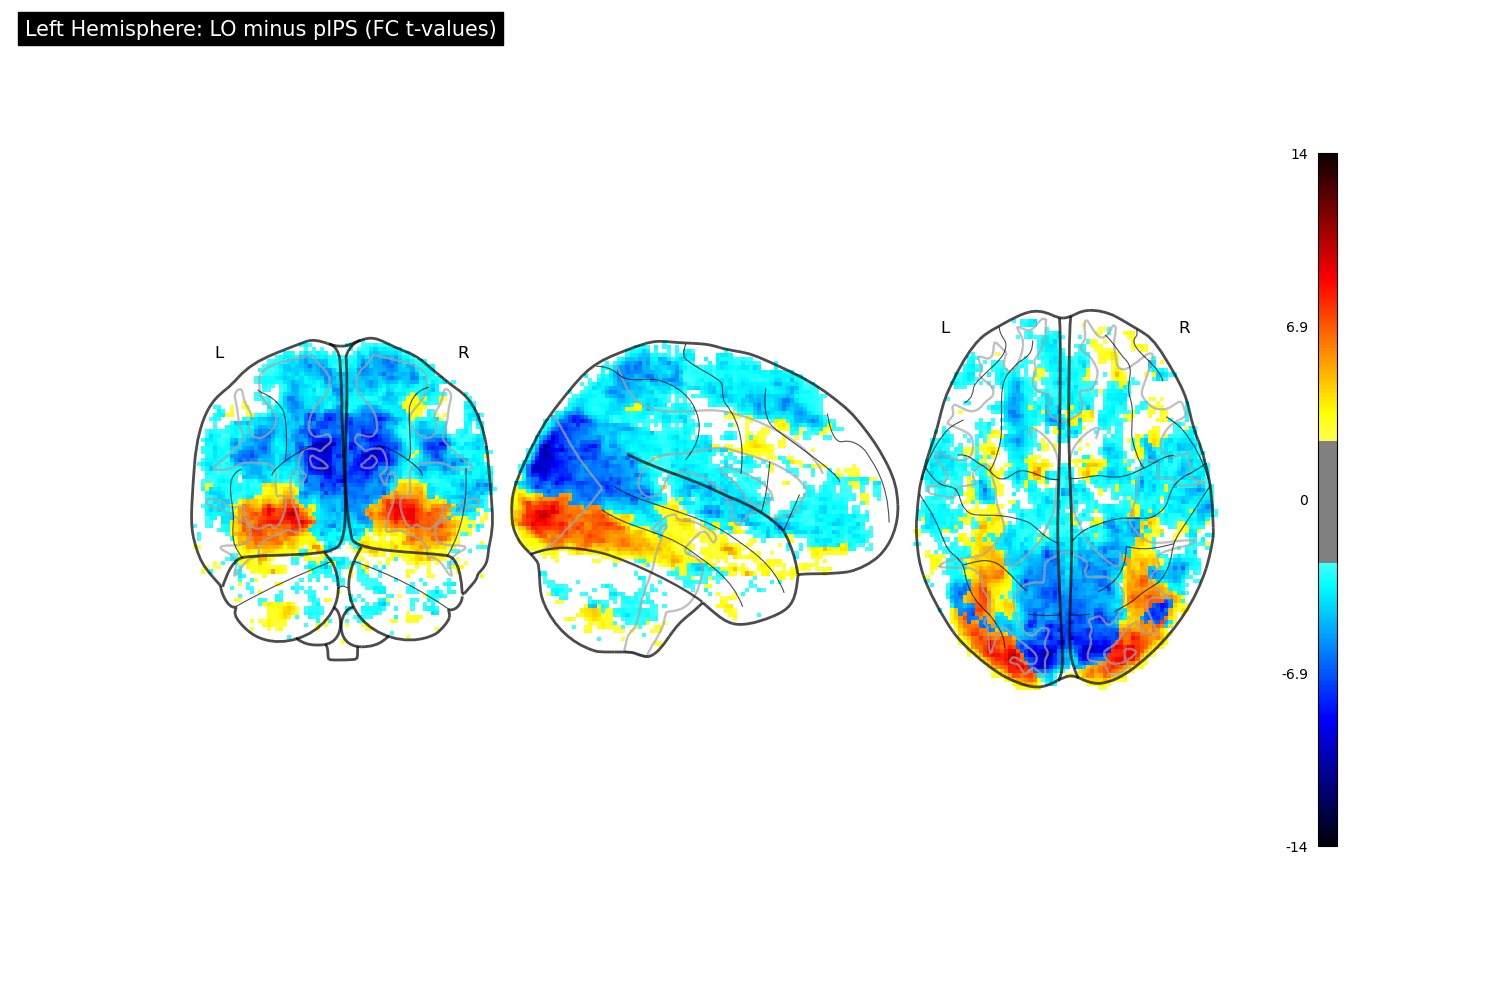

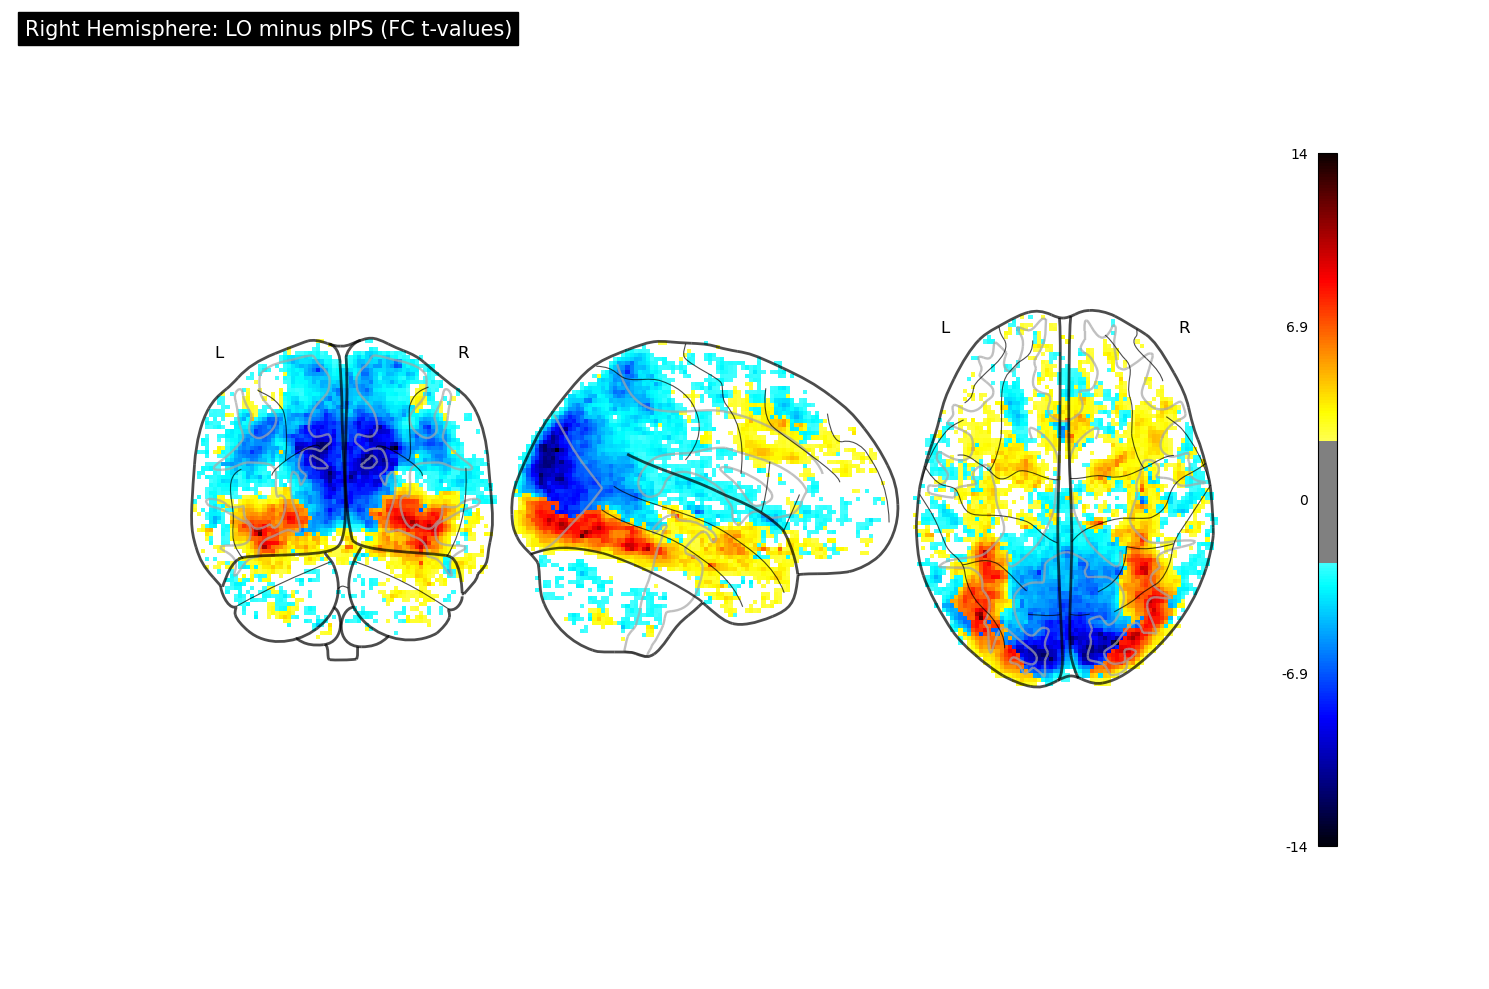


Left Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Right Hemisphere Interactive Plot:


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



Left hemisphere (FC):
  Max t-value: 10.329
  Min t-value: -10.900
  Number of significant voxels: 40288

Right hemisphere (FC):
  Max t-value: 12.251
  Min t-value: -13.839
  Number of significant voxels: 37397

Scale range: -13.839 to 13.839


In [7]:
# Visualize FC Results
import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
group_out_dir = f'{curr_dir}/analyses/fc_subtraction'

# Function to load and threshold t-map
def load_and_threshold_tmap(file_path, threshold):
    img = nib.load(file_path)
    data = img.get_fdata()
    thresholded_data = np.where(np.abs(data) > threshold, data, 0)
    return nib.Nifti1Image(thresholded_data, img.affine, img.header)

# Load t-maps
left_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_left.nii.gz')
right_tmap_file = os.path.join(group_out_dir, 'group_ttest_LO_minus_pIPS_right.nii.gz')

# Set threshold (you can adjust this value)
threshold = 2.5  # This corresponds to p < 0.05 for a two-tailed t-test with large df

# Load and threshold t-maps
left_tmap_thresholded = load_and_threshold_tmap(left_tmap_file, threshold)
right_tmap_thresholded = load_and_threshold_tmap(right_tmap_file, threshold)

# Set a consistent scale for both hemispheres
vmax = max(np.max(np.abs(left_tmap_thresholded.get_fdata())), 
           np.max(np.abs(right_tmap_thresholded.get_fdata())))
vmin = -vmax

# Plot results for left hemisphere
fig_left, ax_left = plt.subplots(figsize=(15, 10))
plotting.plot_glass_brain(left_tmap_thresholded,
                          threshold=threshold,
                          colorbar=True,
                          plot_abs=False,
                          vmin=vmin, vmax=vmax,
                          title='Left Hemisphere: LO minus pIPS (FC t-values)',
                          axes=ax_left)
plt.tight_layout()

# Save the left hemisphere figure
left_fig_path = os.path.join(group_out_dir, 'LO_minus_pIPS_fc_tmap_results_left.png')
fig_left.savefig(left_fig_path, dpi=300, bbox_inches='tight')
print(f"\nLeft hemisphere figure saved as: {left_fig_path}")

# Plot results for right hemisphere
fig_right, ax_right = plt.subplots(figsize=(15, 10))
plotting.plot_glass_brain(right_tmap_thresholded,
                          threshold=threshold,
                          colorbar=True,
                          plot_abs=False,
                          vmin=vmin, vmax=vmax,
                          title='Right Hemisphere: LO minus pIPS (FC t-values)',
                          axes=ax_right)
plt.tight_layout()

# Save the right hemisphere figure
right_fig_path = os.path.join(group_out_dir, 'LO_minus_pIPS_fc_tmap_results_right.png')
fig_right.savefig(right_fig_path, dpi=300, bbox_inches='tight')
print(f"Right hemisphere figure saved as: {right_fig_path}")

# Display the figures
plt.show()

# You can also create interactive plots
print("\nLeft Hemisphere Interactive Plot:")
plotting.view_img(left_tmap_thresholded, threshold=threshold, colorbar=True, 
                  vmin=vmin, vmax=vmax)

print("\nRight Hemisphere Interactive Plot:")
plotting.view_img(right_tmap_thresholded, threshold=threshold, colorbar=True, 
                  vmin=vmin, vmax=vmax)

# Basic Stats
for hemi in ['left', 'right']:
    tmap = nib.load(os.path.join(group_out_dir, f'group_ttest_LO_minus_pIPS_{hemi}.nii.gz'))
    data = tmap.get_fdata()
    significant_voxels = np.sum(np.abs(data) > threshold)
    print(f"\n{hemi.capitalize()} hemisphere (FC):")
    print(f"  Max t-value: {np.max(data):.3f}")
    print(f"  Min t-value: {np.min(data):.3f}")
    print(f"  Number of significant voxels: {significant_voxels}")

print(f"\nScale range: {vmin:.3f} to {vmax:.3f}")